In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score
)

import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [61]:
train = pd.read_csv("train_dataset.csv")
test  = pd.read_csv("test_dataset.csv")

train.head(), test.head()


(   q1_score  q2_score  q3_score  q4_score  q5_score  total_score final_grade
 0  3.374770  0.968922  9.689485  5.793474  6.242745    26.069395           C
 1  7.755053  7.893796  1.951058  7.787626  4.795955    30.183488           B
 2  6.238958  2.088370  9.893550  5.692865  0.241025    24.154769        Fail
 3  0.355902  8.059056  1.282482  3.324825  7.037649    20.059915        Fail
 4  5.771171  9.419105  3.547509  8.456577  6.069714    33.264077           B,
    q1_score  q2_score  q3_score  q4_score  q5_score
 0  9.507143  3.329121  1.845120  4.592925  0.948178
 1  1.560186  4.766242  4.820893  5.878564  2.036533
 2  1.559945  8.657010  7.385710  7.002100  2.422618
 3  7.080726  7.594866  2.303442  3.032015  3.088792
 4  9.699099  7.290337  0.328627  8.956271  5.531397)

In [62]:
target_col = train.columns[-1]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.copy()

target_col


'final_grade'

In [63]:
if y_train.dtype == "object" or y_train.nunique() <= 10:
    problem_type = "classification"
else:
    problem_type = "regression"

problem_type

'classification'

In [64]:
numeric_features = X_train.select_dtypes(include="number").columns.tolist()
categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()

numeric_features, categorical_features

(['q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'total_score'],
 [])

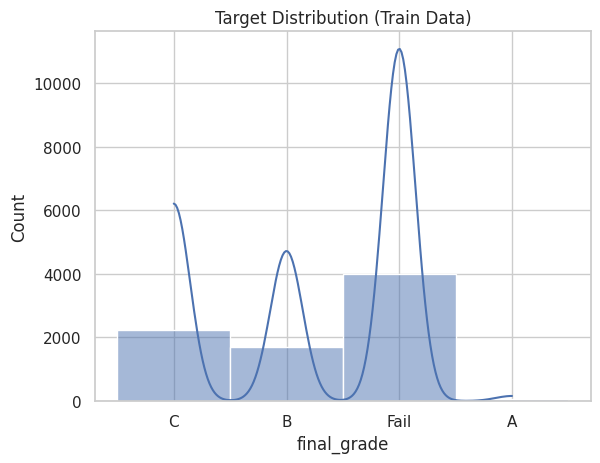

In [65]:
sns.histplot(y_train, kde=True)
plt.title("Target Distribution (Train Data)")
plt.show()

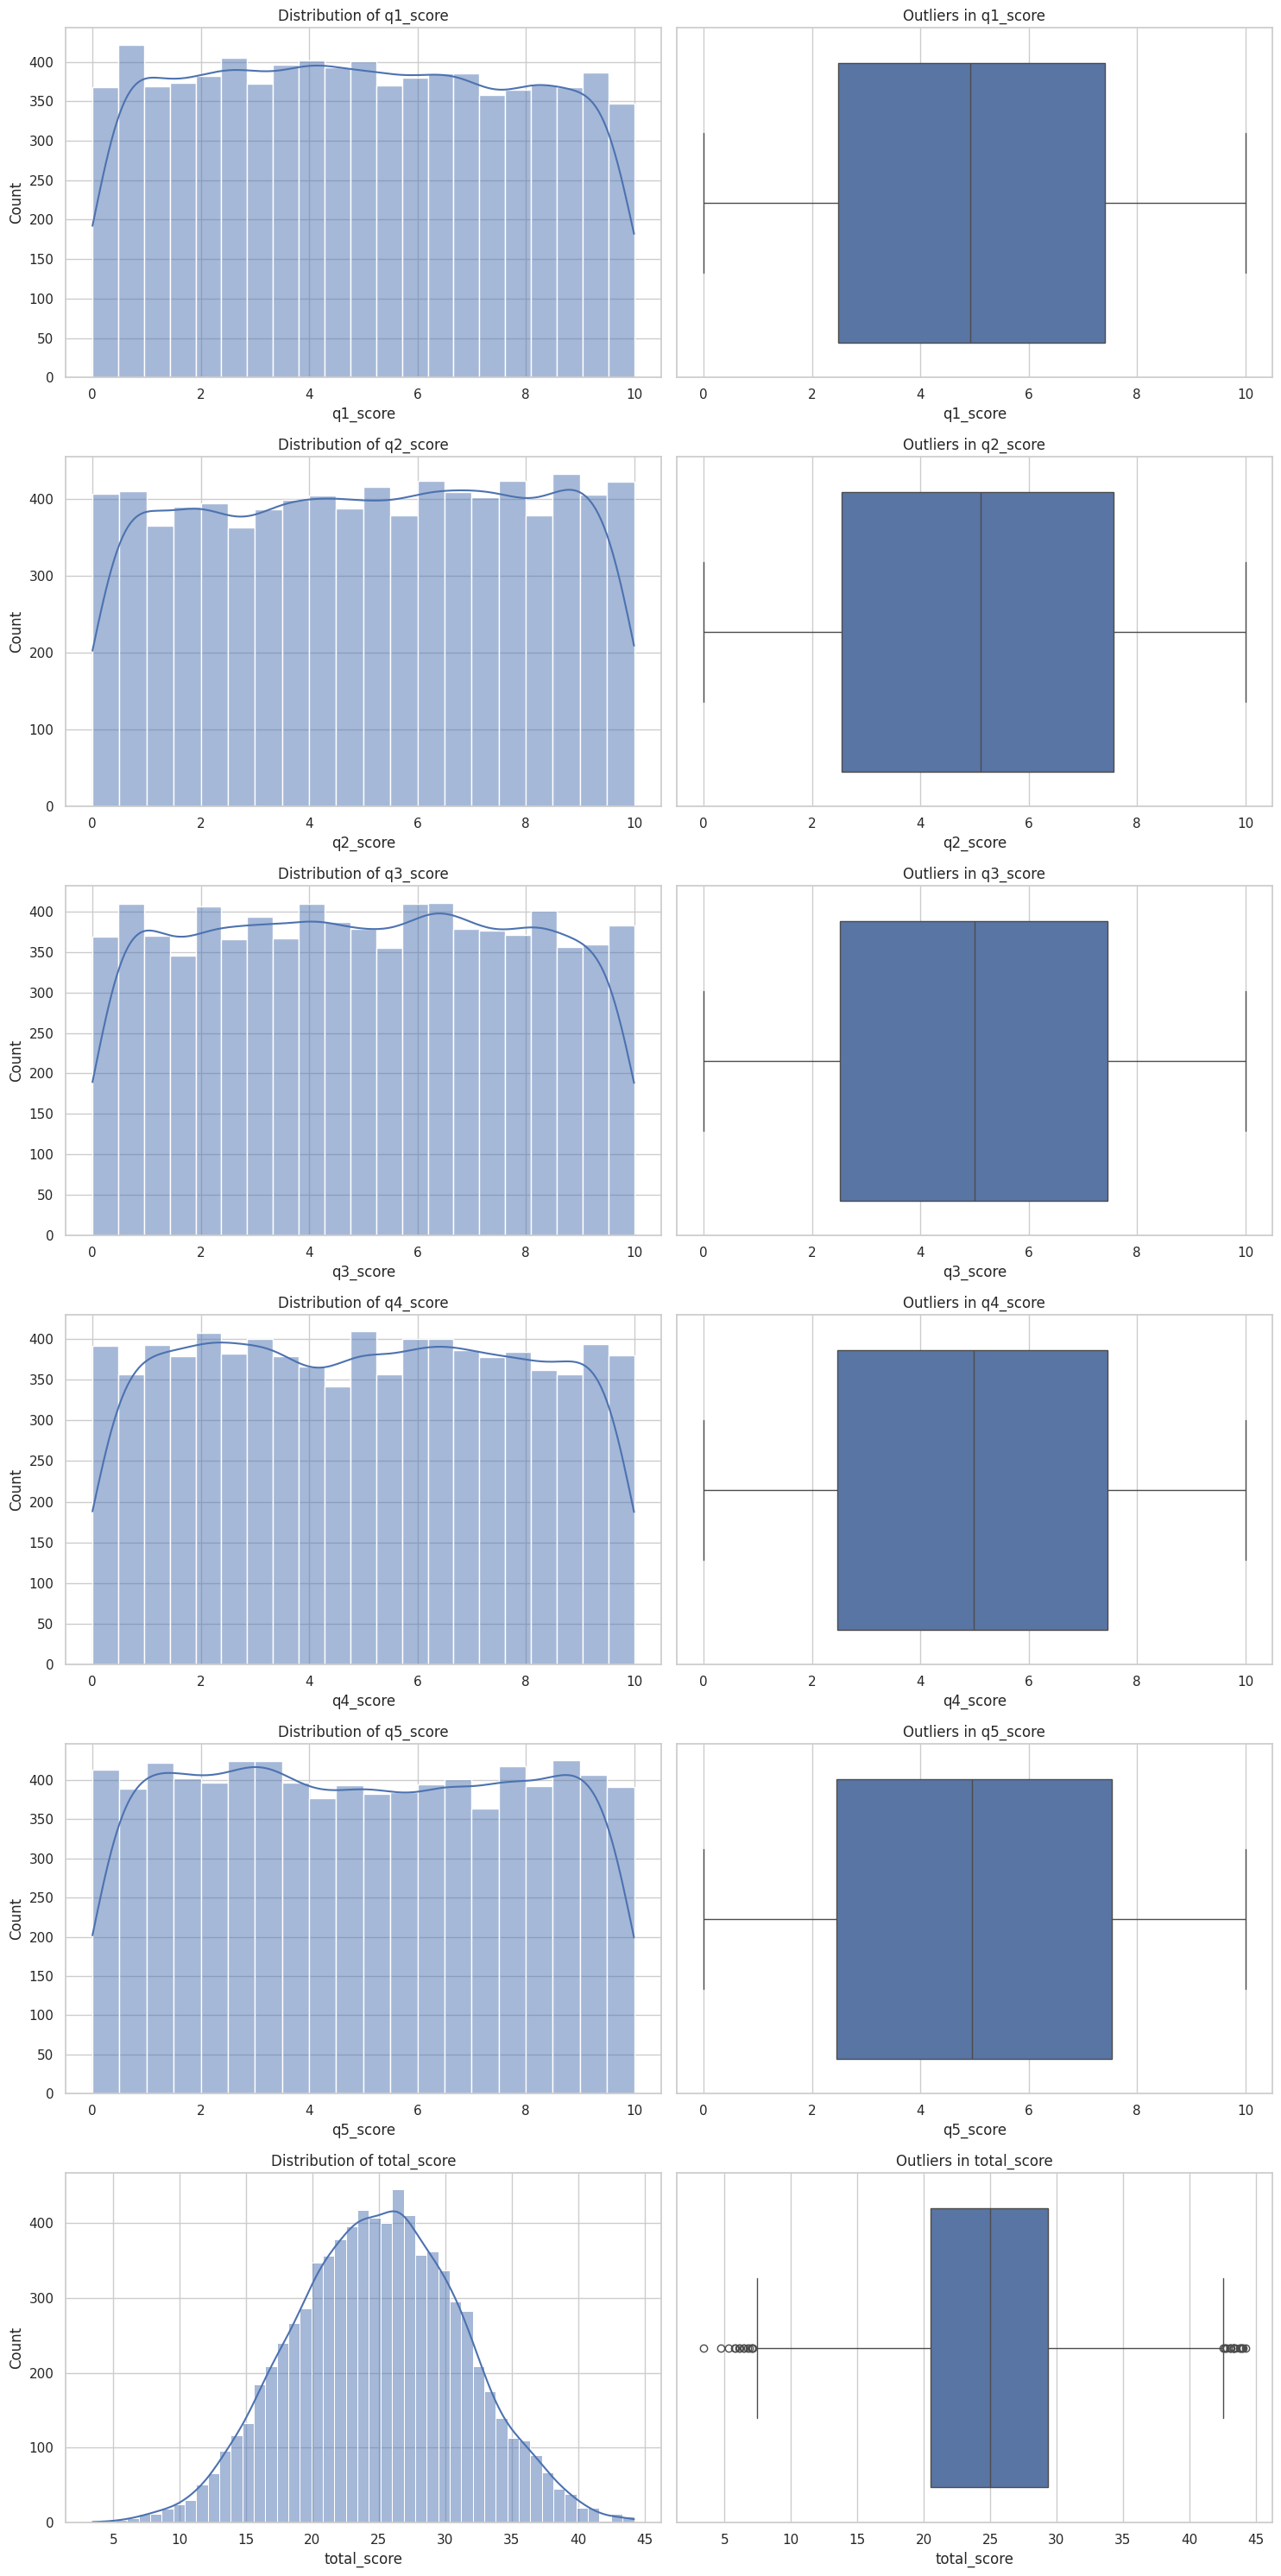

In [66]:
num_features_len = len(numeric_features)
fig, axes = plt.subplots(num_features_len, 2, figsize=(15, 5 * num_features_len))

for i, col in enumerate(numeric_features):
    # Histogram
    sns.histplot(X_train[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {col}")

    # Boxplot
    sns.boxplot(x=X_train[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Outliers in {col}")

plt.tight_layout()
plt.show()

In [67]:
for col in categorical_features:
    X_train[col].value_counts().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.show()

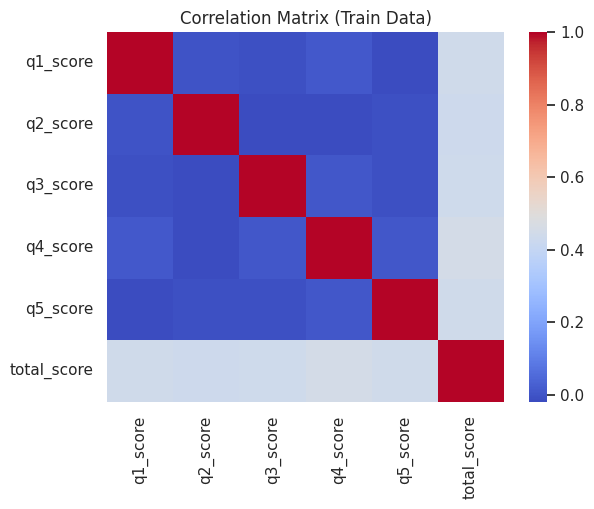

In [68]:
if len(numeric_features) > 1:
    sns.heatmap(train[numeric_features].corr(), # Removed target_col from here
                cmap="coolwarm", annot=False)
    plt.title("Correlation Matrix (Train Data)")
    plt.show()

In [69]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [70]:
if problem_type == "regression":
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(random_state=42)
    }
else:
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(random_state=42)
    }

models

{'LogisticRegression': LogisticRegression(max_iter=1000),
 'RandomForest': RandomForestClassifier(random_state=42)}

In [71]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    if problem_type == "regression":
        score = cross_val_score(
            pipe, X_train, y_train,
            cv=5, scoring="neg_root_mean_squared_error"
        ).mean()
        results[name] = -score
    else:
        score = cross_val_score(
            pipe, X_train, y_train,
            cv=5, scoring="f1_weighted"
        ).mean()
        results[name] = score

results


{'LogisticRegression': np.float64(0.9922680616256496),
 'RandomForest': np.float64(0.9996195116474675)}

In [72]:
best_model_name = (
    min(results, key=results.get)
    if problem_type == "regression"
    else max(results, key=results.get)
)

best_model = models[best_model_name]

best_model_name

'RandomForest'

In [73]:
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['q1_score', 'q2_score',
                                                   'q3_score', 'q4_score',
                                                   'q5_score', 'total_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', RandomForestClassifier(random_state=42))])

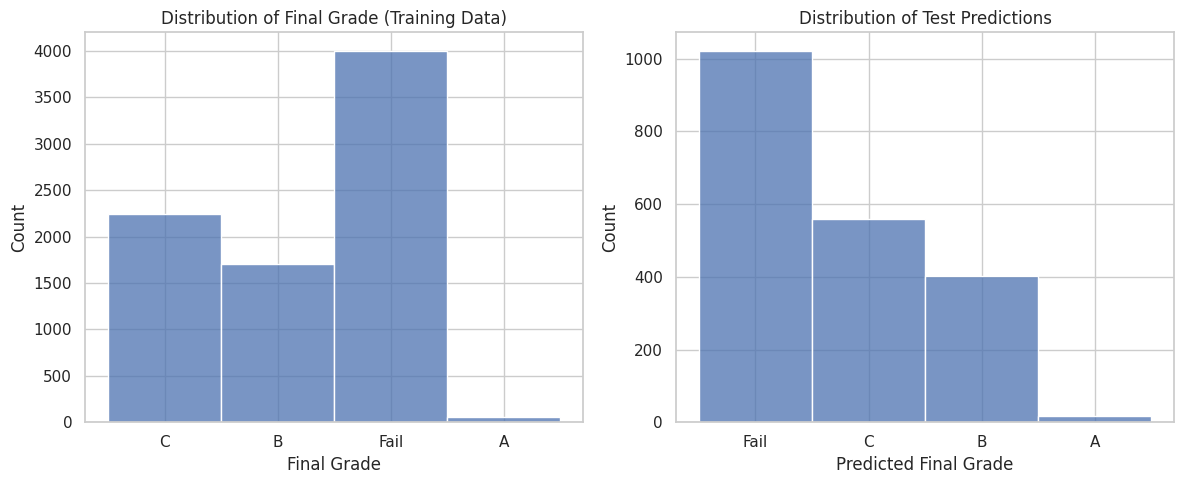

In [74]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=False, discrete=True)
plt.title('Distribution of Final Grade (Training Data)')
plt.xlabel('Final Grade')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(test_predictions, kde=False, discrete=True)
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Final Grade')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


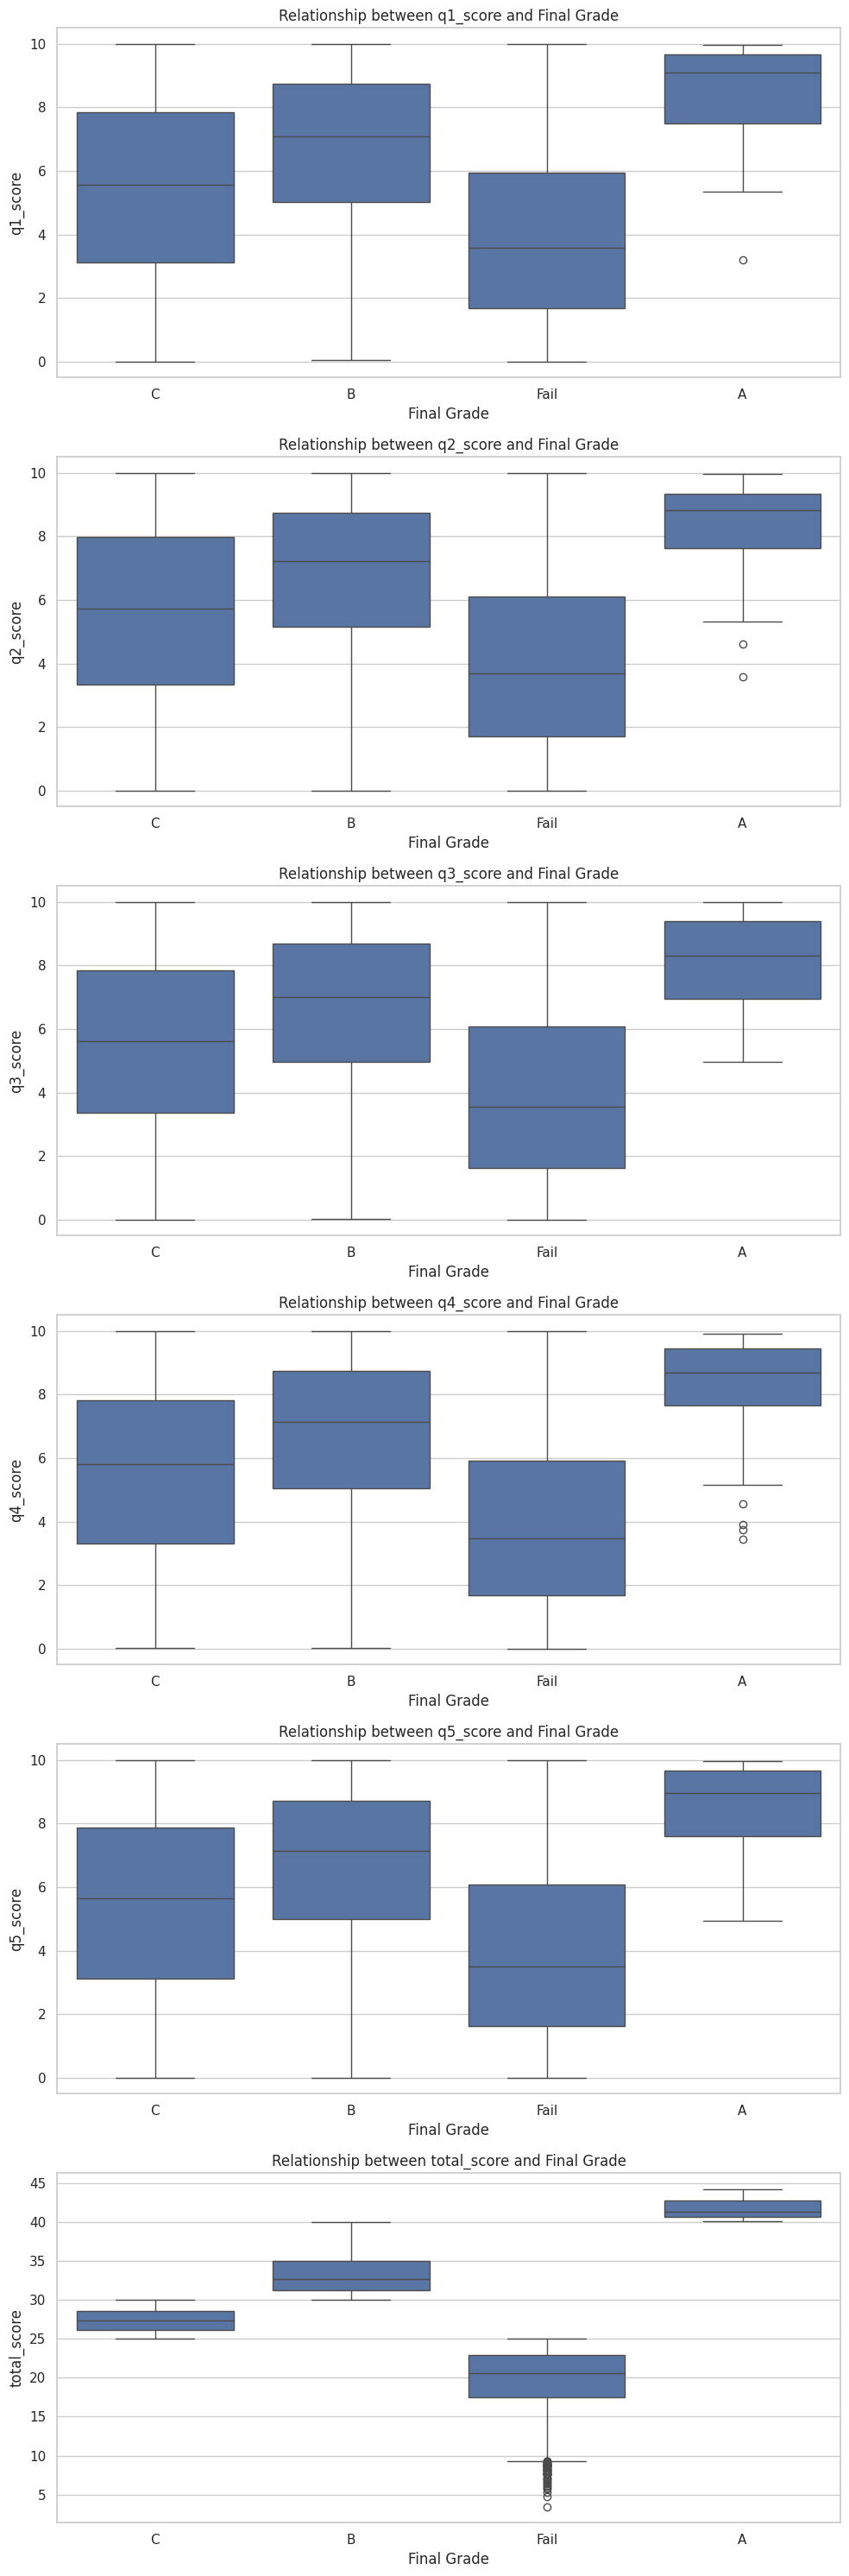

In [75]:
num_features_len = len(numeric_features)
fig, axes = plt.subplots(num_features_len, 1, figsize=(10, 5 * num_features_len))

for i, col in enumerate(numeric_features):
    sns.boxplot(x=y_train, y=X_train[col], ax=axes[i])
    axes[i].set_title(f'Relationship between {col} and Final Grade')
    axes[i].set_xlabel('Final Grade')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

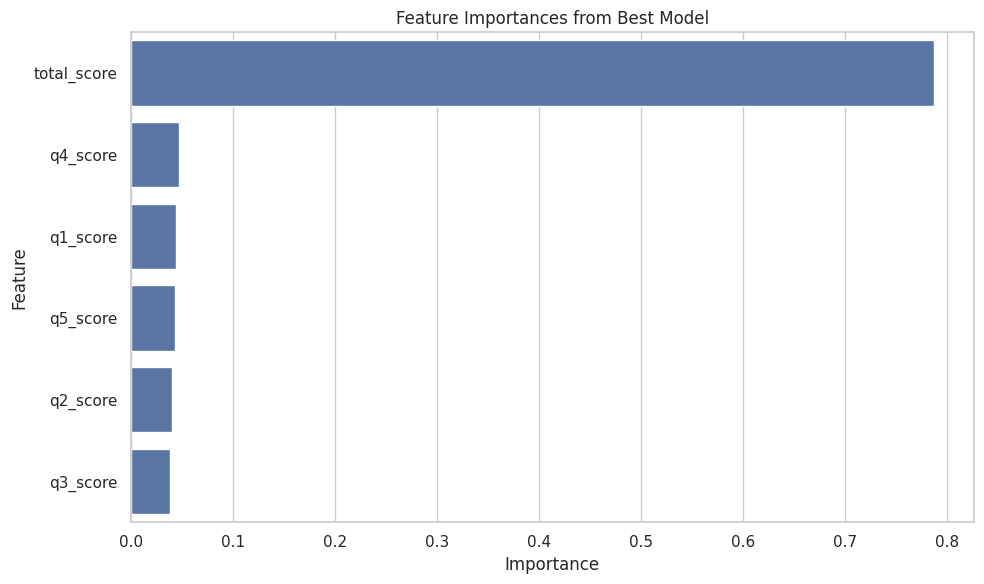

In [76]:
best_model = final_pipeline_loaded.named_steps['model']

if hasattr(best_model, 'feature_importances_'):
    # Get feature names from the preprocessor
    # In this case, only numeric features are present and scaled
    feature_names = numeric_features

    # Get feature importances
    importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances from Best Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print(f"The best model ({best_model_name}) does not have feature importances.")

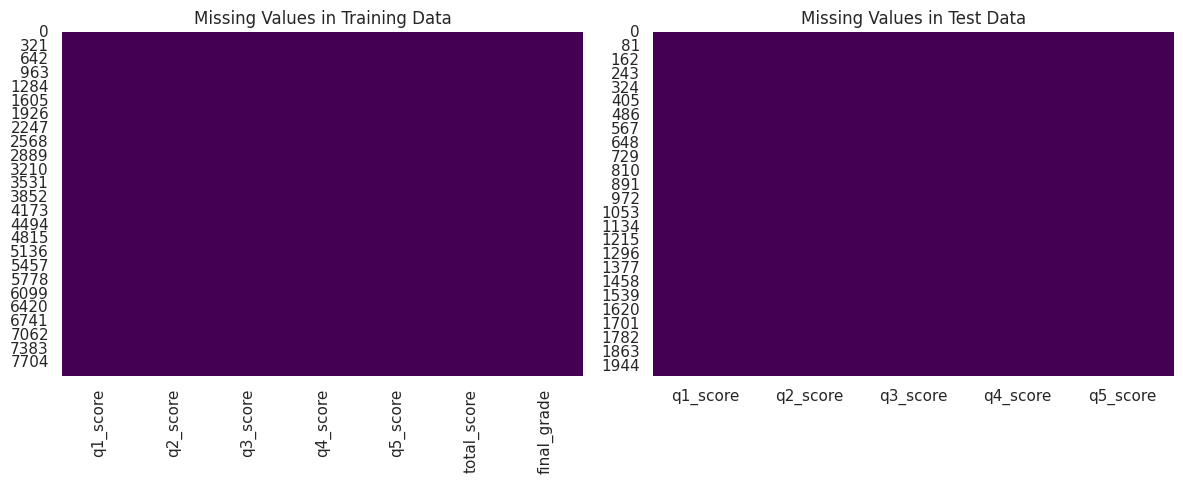

In [77]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')

plt.subplot(1, 2, 2)
sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Test Data')

plt.tight_layout()
plt.show()

In [78]:
X_train[numeric_features].describe()

,q1_score,q2_score,q3_score,q4_score,q5_score,total_score
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4.943580,5.062148,4.992995,4.982647,4.977448,24.958818
std,2.868347,2.897328,2.873422,2.880014,2.902864,6.367436
min,0.000116,0.001577,0.000481,0.000976,0.000167,3.433132
25%,2.483541,2.542456,2.520587,2.468572,2.456092,20.536385
50%,4.920590,5.106285,5.007983,4.988625,4.951150,25.008425
75%,7.403538,7.570337,7.452189,7.460723,7.535297,29.344652
max,9.997177,9.998714,9.999010,9.996972,9.999570,44.216352


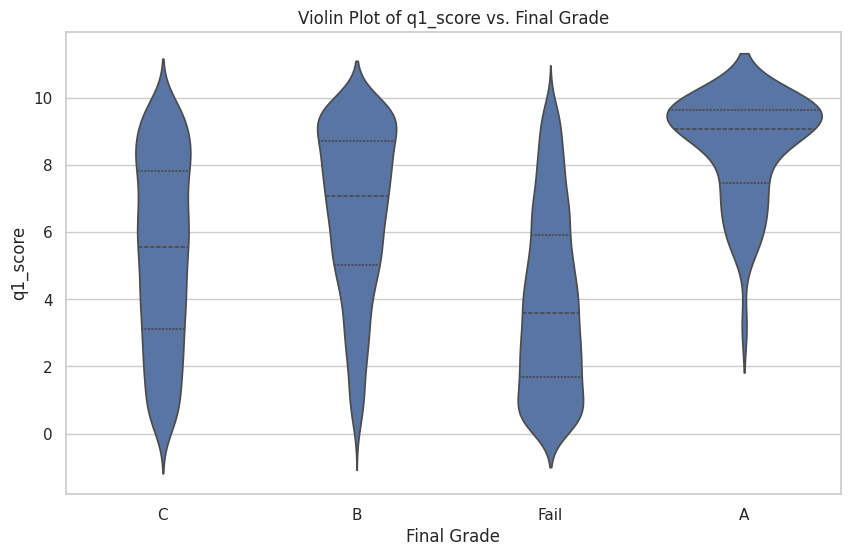

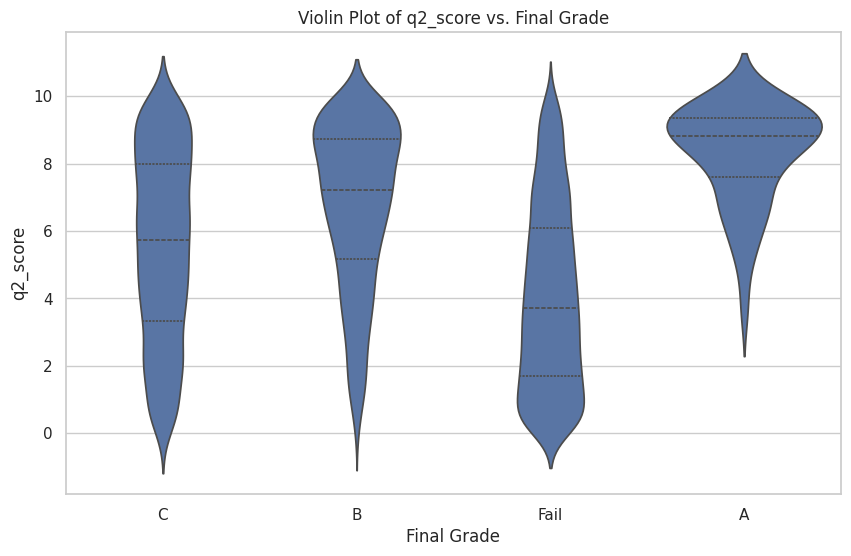

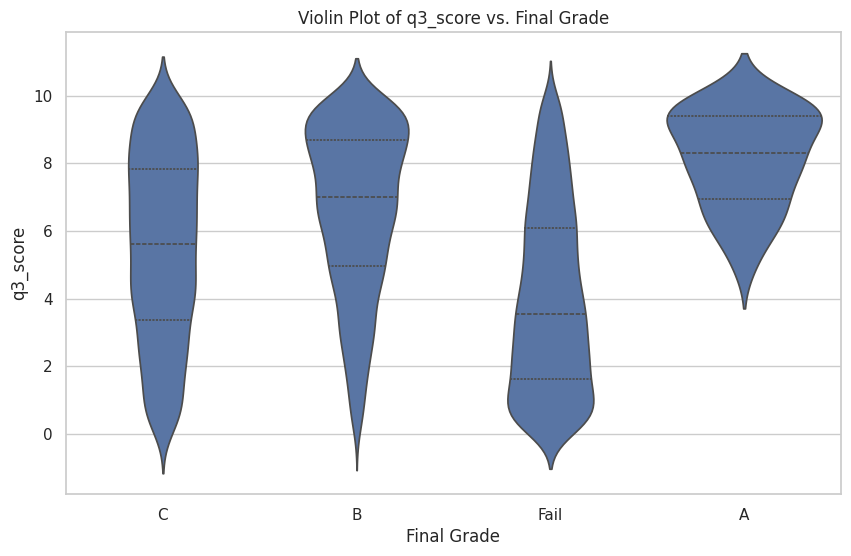

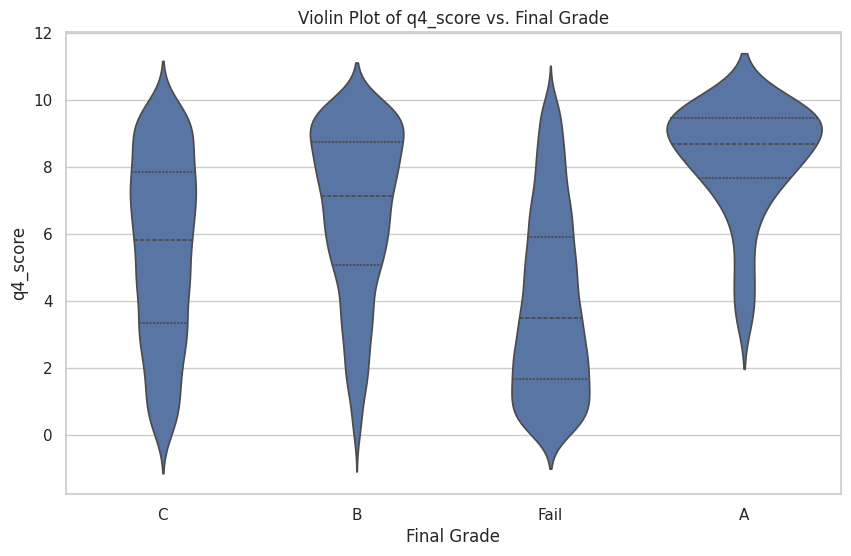

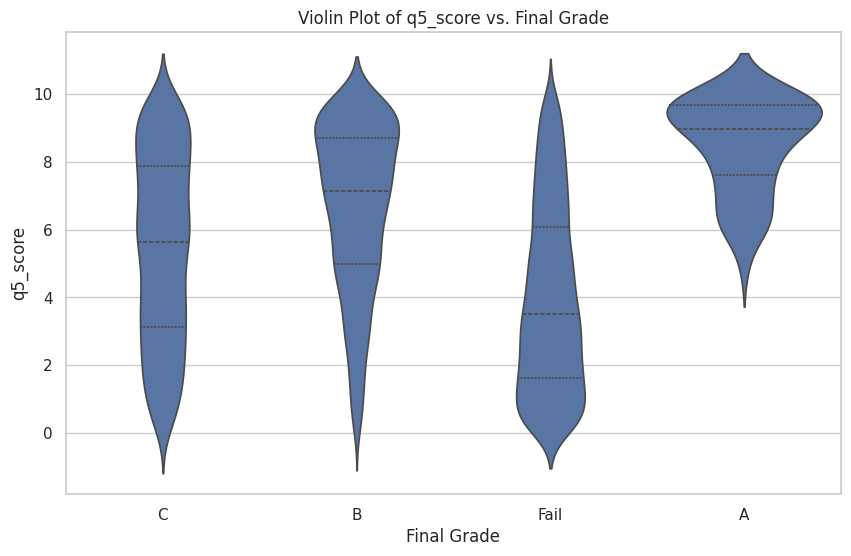

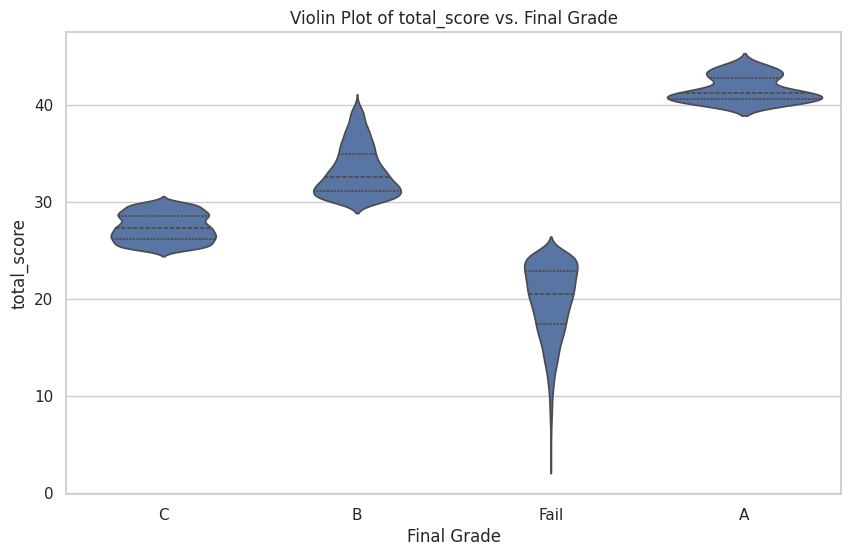

In [79]:
for col in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=y_train, y=X_train[col], inner="quartile")
    plt.title(f'Violin Plot of {col} vs. Final Grade')
    plt.xlabel('Final Grade')
    plt.ylabel(col)
    plt.show()

In [80]:
print('Value counts for y_train (final_grade in training data):\n', y_train.value_counts())
print('\nValue counts for test_predictions:\n', pd.Series(test_predictions).value_counts())

# Calculate 'total_score' for X_test, assuming it's the sum of q1_score to q5_score
X_test['total_score'] = X_test[['q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score']].sum(axis=1)

X_test.head()

test_predictions = final_pipeline.predict(X_test)

test_predictions[:10]

Value counts for y_train (final_grade in training data):
 final_grade
Fail    3999
C       2241
B       1703
A         57
Name: count, dtype: int64

Value counts for test_predictions:
 Fail    1021
C        559
B        402
A         18
Name: count, dtype: int64


array(['Fail', 'Fail', 'C', 'Fail', 'B', 'C', 'Fail', 'C', 'Fail', 'B'],
      dtype=object)

In [81]:
submission = pd.DataFrame({
    "prediction": test_predictions
})

submission.to_csv("submission.csv", index=False)
submission.head()

joblib.dump(final_pipeline, "final_model.pkl")
print("Model saved successfully.")

Model saved successfully.
